# Parametric linear elastic equation 

This notebook implements linear elastic deformation of thin plate where Young's modulus is uncertain and sampled from log-normal like distribution. Dependencies are mentioned in the `neuralop.yml` file in the root directory of this repository. 

## Problem description
We consider the in-plane deformation of the thin plate with the center plane given by $\Omega = (0, 1) \times (0, 1) \subset\mathbb{R}^2$. Suppose $E(x)$ is the Young's modulus at a point $x\in \Omega$ and $\nu$ Poisson ratio, $u = (u_1, u_2) : \Omega \to \mathbb{R}^2$ displacement field, $e(x) = \mathrm{sym} \nabla u = (\nabla u + \nabla u^T)/2$ linearized strain, $\sigma(x)$ Cauchy stress, and $b(x)$ body force per unit volume. The equation for $u$ is based on the balance of linear momentum and reads:
\begin{equation}\tag{1}
    \begin{aligned}
        -\nabla \cdot \sigma(x) &= b(x)\,, \qquad & \forall x\in \Omega\,,\\
        \sigma(x) &= \lambda(x) e_{ii} \mathrm{Id} + 2\mu(x) e\,, \qquad & \forall x \in \Omega\,,\\
        u(x) &= 0\,,\qquad &\forall x\in \Gamma_u\,,\\
        \sigma(x) n(x) &= t(x)\,, \qquad &\forall x\in \Gamma_q\,,\\
    \end{aligned}
\end{equation}
where, $\lambda$ and $\mu$ are Lam\'e parameters and are related to $E$ and $\nu$ as follows:
\begin{equation}\tag{2}
    \lambda(x) = \frac{E(x) \nu}{(1+\nu)(1-2\nu)} \quad \text{and} \quad \mu(x) = \frac{E(x)}{2(1+\nu)}\,.
\end{equation}
In Eq (1), $\Gamma_u := \left\{x\in \partial \Omega: x_1 < 1 \right\}$ and $\Gamma_q := \partial \Omega - \Gamma_u$, $n$ unit outward normal, and $t$ specified traction on the right edge of the domain. We assume that the field $E\in M$ is uncertain and the forward map $F: M \to U$ is defined such that given $E\in M$, $F(m) = u \in U$ solves the BVP Eq (1). The probability distribution for $E$ is given by
\begin{equation}\tag{3}
    E = \alpha_m * \log(w) + \mu_m, \qquad \text{where} \quad w \sim N(0, C)\,,
\end{equation}
with $C$ is the covariance operator and takes the same form as in [Poisson problem](../poisson/Poisson.ipynb). 

## Fixing parameters
We let
\begin{equation}\tag{4}
    b(x) = 0 \quad \text{and} \quad t(x) = 0e_1 + 10 e_2 
\end{equation}
and
\begin{equation}\tag{5}
\gamma_C = 0.8\,, \quad \delta_C = 0.2\,,\quad \eta_C = 1\,,\quad d_C = 2\,, \quad \alpha_m = 100\,, \quad \mu_m = 1000\,.
\end{equation}

## Random samples of m and corresponding solution u(m)

<p align="center"> <img src="./data/LinearElasticity_sample_plots.png" width="600"> </p>

In [1]:
import sys
import os
import time
import numpy as np
import dolfin as dl
import hippylib as hp

util_path = "../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_fenics
from classUtilities import GenericReprBase

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)

In [2]:
data_folder = 'data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/' + data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Main model class
This will also be moved to a python script after testing. The class has two component: (1) class to sample Young's modulus field using log-normal distribution in infinite dimension and (2) class that implements the variational form and solves it. 

In [3]:
class PriorSampler(GenericReprBase):
    
    def __init__(self, Vm, correlation_length, seed = 0, logn_scale = 100., logn_translate = 1000.):

        self.correlation_length = correlation_length
        var = self.correlation_length / 0.16
        # Delta and gamma
        self.delta = (var * self.correlation_length) ** (-0.5)
        self.gamma = self.delta * self.correlation_length ** 2

        self.seed = seed
        self.Vm = Vm

        self.prior = hp.BiLaplacianPrior(self.Vm, self.gamma, self.delta, robin_bc=True)
        self.translate = dl.Constant(logn_translate)
        self.scale = dl.Constant(logn_scale)
        
        self.parRandom = hp.Random(seed = seed)

        # initialize noise vector
        self.noise = dl.Vector()
        self.prior.init_vector(self.noise, "noise")
        self.parRandom.normal(1.,self.noise)
        
        # initialize sample
        self.sample = dl.Vector()
        self.prior.init_vector(self.sample, 0)

        # draw a sample
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.m_local = None
        self.m_fn = dl.Function(self.Vm)
        self.m_transform_fn = dl.Function(self.Vm)

        # set mean
        self.mean = self.prior.mean.copy()
        self.transform(self.mean)

    def transform(self, m):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., m)
        self.m_transform_fn = self.scale * dl.exp(self.m_fn) + self.translate
        
        self.m_local = dl.project(self.m_transform_fn, self.Vm).vector().get_local()
        m.set_local(self.m_local)


    def transform_pointwise(self, m):
        self.m_local = self.scale.values()[0]*np.exp(m.get_local()) + self.translate.values()[0]
        m.set_local(self.m_local)

    def get(self):
        self.sample.zero()
        self.parRandom.normal(1.,self.noise)
        self.prior.sample(self.noise, self.sample)

        self.transform_pointwise(self.sample)
        return self.sample
    
class LinearElasticityModel(GenericReprBase):
    
    def __init__(self, correlation_length, seed = 0):
        
        # FE setup
        self.fe_order = 1
        self.nx = 50
        self.ny = 50
        self.mesh = dl.RectangleMesh(dl.Point(0, 0), dl.Point(1,1), self.nx, self.ny)
        self.Vu = dl.VectorFunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vm = dl.FunctionSpace(self.mesh, "Lagrange", self.fe_order)
        self.Vh = [self.Vu, self.Vm, self.Vu] # state, parameter, adjoint

        # Boundary conditions
        self.b = dl.Constant((0, 0))
        self.t = dl.Constant((0, 10))
        
        self.bc = [dl.DirichletBC(self.Vu, dl.Constant((0,0)), self.boundaryLeft)]

        facets = dl.MeshFunction("size_t", self.mesh, self.mesh.topology().dim()-1)
        dl.AutoSubDomain(self.boundaryRight).mark(facets, 1)
        self.ds = dl.Measure("ds", domain=self.mesh, subdomain_data=facets)

        # variational form
        self.m_fn = dl.Function(self.Vm)
        self.u_fn = dl.Function(self.Vu)
        self.nu = 0.25
        self.lam_fact = dl.Constant(self.nu / (1+self.nu)*(1-2*self.nu))
        self.mu_fact = dl.Constant(1/(2*(1+self.nu)))
        
        self.u_trial = dl.TrialFunction(self.Vu)
        self.u_test = dl.TestFunction(self.Vu)

        self.d = self.u_fn.geometric_dimension()  # space dimension
        self.a = self.m_fn*dl.inner(self.lam_fact*dl.tr(dl.grad(self.u_trial))*dl.Identity(self.d) \
                                        + 2*self.mu_fact * dl.sym(dl.grad(self.u_trial)), \
                                    dl.sym(dl.grad(self.u_test)))*dl.dx
        
        self.L = dl.inner(self.b, self.u_test)*dl.dx + dl.inner(self.t, self.u_test)*self.ds 

        self.varf = self.a - self.L
    
        # setup prior for parameter field m
        self.prior_sampler = PriorSampler(self.Vm, correlation_length, seed)
        
    @staticmethod
    def boundaryLeft(x, on_boundary):
        return on_boundary and dl.near(x[0], 0.)
    
    @staticmethod
    def boundaryRight(x, on_boundary):
        return on_boundary and dl.near(x[0], 1.)
    
    def epsilon(self):
        return dl.sym(dl.grad(self.u_fn))

    def sigma(self):
        return self.m_fn*self.lam_fact*dl.tr(dl.grad(self.u_fn))*dl.Identity(self.d) \
                                        + 2*self.m_fn*self.mu_fact * dl.sym(dl.grad(self.u_fn))

    def solveFwd(self, m = None, m_is_fn = True):
        if m is not None:
            self.m_fn.vector().zero()
            if m_is_fn:
                self.m_fn.vector().axpy(1., m.vector())
            else:
                self.m_fn.vector()[:] = m


        self.A = dl.assemble(self.a)
        self.b = dl.assemble(self.L)
        for bc in self.bc:
            bc.apply(self.A, self.b)
        
        dl.solve(self.A, self.u_fn.vector(), self.b)

    def samplePrior(self):
        self.m_fn.vector().zero()
        self.m_fn.vector().axpy(1., self.prior_sampler.get())

# Test LinearElasticity model

In [4]:
correlation_length = 2
model = LinearElasticityModel(correlation_length)
print(model.prior_sampler.gamma, model.prior_sampler.delta)

0.8 0.2


## Generate few samples of Youngs modulus and solve the forward problem

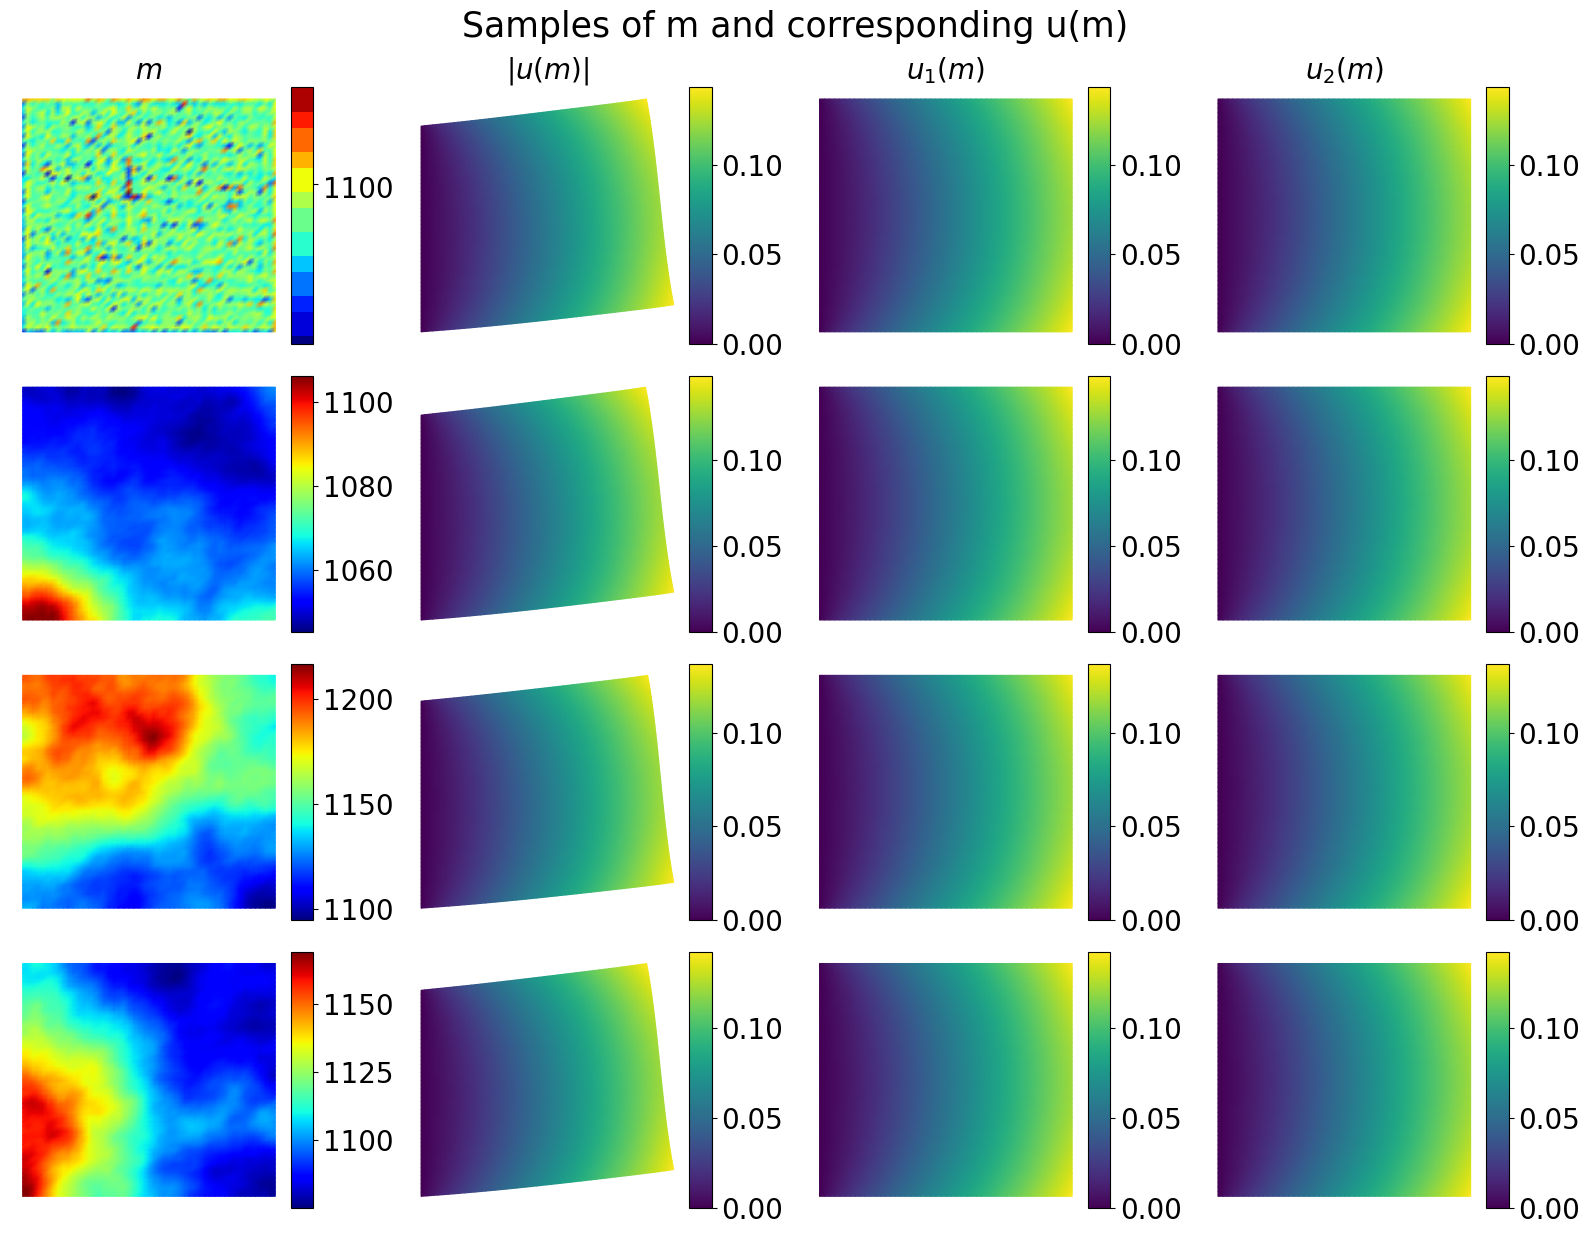

In [5]:
rows = 4
cols = 4 # m, |u(m)|, u1, u2
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 12))

u_vec = None
u_tag = [r'$m$', r'$|u(m)|$', r'$u_1(m)$', r'$u_2(m)$']
cmap_vec = ['jet', 'viridis', 'viridis', 'viridis']

m = dl.Function(model.Vm).vector()
u = dl.Function(model.Vu).vector()

for i in range(rows):

    m.zero()
    if i > 0:
        m.axpy(1., model.prior_sampler.get())
    else:
        m.axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m, m_is_fn = False)
    u = model.u_fn.vector()
    u1 = model.u_fn.sub(0).vector()
    u2 = model.u_fn.sub(1).vector()
    
    u_vec = [m, u, u1, u2]

    for j in range(cols):
        V = model.Vu
        if j == 0:
            V = model.Vm

        if j == 1:
            cbar = field_plot_fenics(axs[i,j], u_vec[j], \
                                     V, \
                                     cmap = cmap_vec[j], add_displacement_to_nodes = True, \
                                     is_displacement = True)
        else:
            cbar = field_plot_fenics(axs[i,j], u_vec[j], \
                                     V, cmap = cmap_vec[j])
        
        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j== 0:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')
        
        if i == 0:
            axs[i,j].set_title(u_tag[j], fontsize=fs)
        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Samples of m and corresponding u(m)', fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'LinearElasticity_sample_plots.png',  bbox_inches='tight')
plt.show()

In [6]:
a = model.prior_sampler.mean.get_local()
print('mean:', a.mean(), a.min(), a.max())
a = model.prior_sampler.get().get_local()
print('sample:', a.mean(), a.min(), a.max())

mean: 1099.9999999999989 1099.9999999999964 1100.000000000002
sample: 1148.3446922348544 1086.3289372951315 1269.9181228589957


## Generate data

In [7]:
m = dl.Function(model.Vm).vector()
m.axpy(1., model.prior_sampler.mean)

model.solveFwd(m, m_is_fn = False)

u1, u2 = model.u_fn.sub(0, deepcopy=True), model.u_fn.sub(1, deepcopy=True)
u1_vec = u1.vector().get_local()
u2_vec = u2.vector().get_local()

u1_size = u1_vec.shape[0]
u2_size = u2_vec.shape[0]
print('u1_size:', u1_size, 'u2_size:', u2_size)


u1_size: 2601 u2_size: 2601


In [9]:
num_samples = 2000

# get the sample dimensions

m_samples = np.zeros((num_samples, model.Vm.dim()))
u_samples = np.zeros((num_samples, model.Vu.dim()))

m = dl.Function(model.Vm).vector()

for i in range(num_samples):

    start_time = time.perf_counter()

    m.zero()
    if i > 0:
        m.axpy(1., model.prior_sampler.get())
    else:
        m.axpy(1., model.prior_sampler.mean)
    
    model.solveFwd(m, m_is_fn = False)

    # save
    m_samples[i, :] = m.get_local()
    u_samples[i, :] = model.u_fn.vector().get_local()

    end_time = time.perf_counter()
    epoch_time = end_time - start_time

    if i % 100 == 0:
        print('Sample {:4d} took {:.3f} seconds'.format(i, epoch_time))

print(m_samples.shape, u_samples.shape)


Sample    0 took 0.106 seconds
Sample  100 took 0.066 seconds
Sample  200 took 0.081 seconds
Sample  300 took 0.065 seconds
Sample  400 took 0.062 seconds
Sample  500 took 0.061 seconds
Sample  600 took 0.062 seconds
Sample  700 took 0.071 seconds
Sample  800 took 0.142 seconds
Sample  900 took 0.060 seconds
Sample 1000 took 0.059 seconds
Sample 1100 took 0.071 seconds
Sample 1200 took 0.069 seconds
Sample 1300 took 0.068 seconds
Sample 1400 took 0.063 seconds
Sample 1500 took 0.062 seconds
Sample 1600 took 0.064 seconds
Sample 1700 took 0.070 seconds
Sample 1800 took 0.083 seconds
Sample 1900 took 0.072 seconds
(2000, 2601) (2000, 5202)


In [10]:
# data to save
np.savez(results_dir + 'LinearElasticity_samples.npz', \
        m_samples = m_samples, \
        u_samples = u_samples, num_samples = num_samples, \
        m_dim = model.Vm.dim(), u_dim = model.Vu.dim(), \
        fe_order = model.fe_order, nx = model.nx, ny = model.ny, \
        correlation_length = correlation_length, \
        gamma = model.prior_sampler.gamma, \
        delta = model.prior_sampler.delta, \
        alpha_m = model.prior_sampler.scale.values()[0], \
        mu_m = model.prior_sampler.translate.values()[0], \
        u_mesh_nodes = model.Vu.mesh().coordinates(), \
        m_mesh_nodes = model.Vm.mesh().coordinates(), \
        u_mesh_elements = model.Vu.mesh().cells(), \
        m_mesh_elements = model.Vm.mesh().cells())


# save mesh 
## to read, use the syntax
## mesh = dl.Mesh()
## with dl.XDMFFile(results_dir + 'u_mesh.xdmf') as infile:
##     infile.read(mesh)
with dl.XDMFFile(results_dir + 'LinearElasticity_u_mesh.xdmf') as infile:
    infile.write(model.Vu.mesh())

with dl.XDMFFile(results_dir + 'LinearElasticity_m_mesh.xdmf') as infile:
    infile.write(model.Vm.mesh())

In [11]:
model.Vu.mesh().coordinates().shape, model.Vu.mesh().cells().shape, model.Vm.dim(), model.Vu.dim()

((2601, 2), (5000, 3), 2601, 5202)

### Test data by loading

In [12]:
data_load = np.load(results_dir + 'LinearElasticity_samples.npz')
data_load['m_samples'].shape, data_load['u_samples'].shape, data_load['m_dim'], data_load['u_dim']

((2000, 2601), (2000, 5202), array(2601), array(5202))

In [13]:
X = data_load['u_mesh_nodes']
X.shape, np.min(X, axis = 0), np.max(X, axis = 0)  

((2601, 2), array([0., 0.]), array([1., 1.]))